# Inspect GRPO rollout traces

Rollouts are saved as **tokenized** JSONL: one JSON object per line with `prompt_tokens`, `response_tokens` (token IDs), and optionally `logprobs` (vLLM logprobs per response token). Files can be very large (multi-GB). This notebook streams them line-by-line to avoid loading everything into memory.

**RolloutRecord fields:** `step`, `sample_idx`, `prompt_idx`, `prompt_tokens`, `response_tokens`, `reward`, `advantage`, `finish_reason`, `dataset`, `ground_truth`, `request_info`, `logprobs`

**Note:** The saved `logprobs` are from **vLLM** at rollout time. To compare with local policy logprobs (e.g. for debugging `vllm_vs_local_logprob_diff_mean`), you would need to run a separate forward pass on the same tokens with the learner model; this notebook only inspects the stored vLLM logprobs and metrics.

## 1. Configuration

In [2]:
import json
import os
from collections import defaultdict
from pathlib import Path

import numpy as np
import pandas as pd

# Path to the rollouts directory (contains *_metadata.jsonl and *_rollouts_*.jsonl)
ROLLOUTS_DIR = "/mnt/vast/home/lh22zyta/shortcut-RL/open-instruct/output/RLVR-soofi-basev2/rollouts"
# ROLLOUTS_DIR = "/mnt/vast/home/lh22zyta/shortcut-RL/open-instruct/output/RLVR-soofi-Basev2-Isomorphic-RLv2/rollouts"

# Optional: restrict to a specific run (prefix of rollout filenames). If None, use first run found.
RUN_NAME = "RLVR-soofi-basev2__1__1771322614"  # or None for auto
# RUN_NAME = "RLVR-soofi-Basev2-Isomorphic-RLv2__1__1771002079"  # or None for auto

# Limit number of lines to read per file (None = no limit). Use for quick checks on huge files.
MAX_LINES_PER_FILE = None  # e.g. 50_000

# Step range to load (None = all steps). Reduces memory when inspecting a window.
STEP_MIN = None  # e.g. 400
STEP_MAX = None  # e.g. 600

# How many full records to keep in memory for detailed inspection (rest are aggregated as stats only)
NUM_SAMPLE_RECORDS = 5

## 2. List rollout files and load metadata

In [3]:
def get_rollout_files(rollouts_dir: str, run_name: str | None = None) -> tuple[list[str], str | None, dict | None]:
    """List rollout JSONL paths and return (paths, run_name, metadata_dict)."""
    base = Path(rollouts_dir)
    if not base.is_dir():
        raise FileNotFoundError(f"Not a directory: {rollouts_dir}")

    if run_name is None:
        # Infer run_name from first metadata file
        metas = sorted(base.glob("*_metadata.jsonl"))
        if not metas:
            raise FileNotFoundError(f"No *_metadata.jsonl in {rollouts_dir}")
        run_name = metas[0].stem.replace("_metadata", "")

    meta_path = base / f"{run_name}_metadata.jsonl"
    metadata = None
    if meta_path.exists():
        with open(meta_path) as f:
            metadata = json.loads(f.readline())

    paths = sorted(base.glob(f"{run_name}_rollouts_*.jsonl"))
    return [str(p) for p in paths], run_name, metadata


paths, run_name, metadata = get_rollout_files(ROLLOUTS_DIR, RUN_NAME)
print(f"Run: {run_name}")
print(f"Rollout files: {len(paths)}")
for p in paths:
    size_mb = os.path.getsize(p) / (1024 * 1024)
    print(f"  {os.path.basename(p)}  ({size_mb:.1f} MB)")
if metadata:
    print(f"Metadata: {metadata}")

Run: RLVR-soofi-basev2__1__1771322614
Rollout files: 1
  RLVR-soofi-basev2__1__1771322614_rollouts_000000.jsonl  (907.2 MB)
Metadata: {'run_name': 'RLVR-soofi-basev2__1__1771322614', 'git_commit': 'd64832d7', 'model_name': 'allenai/Olmo-3-7B-Think-DPO', 'timestamp': '2026-02-17T10:04:50.956053+00:00'}


## 3. Stream rollouts and aggregate stats (memory-efficient)

In [12]:
def stream_rollouts(
    paths: list[str],
    step_min: int | None = None,
    step_max: int | None = None,
    max_lines_per_file: int | None = None,
    num_sample_records: int = 5,
):
    """
    Iterate over JSONL files line-by-line. For each record:
    - Aggregate per-step stats (reward, advantage, response length, logprobs).
    - Keep up to num_sample_records full records (spread across steps) for inspection.
    """
    step_records = defaultdict(list)  # step -> list of lightweight dicts
    sample_records = []  # full records for display
    steps_seen = set()
    total_lines = 0

    for filepath in paths:
        lines_read = 0
        with open(filepath) as f:
            for line in f:
                if max_lines_per_file is not None and lines_read >= max_lines_per_file:
                    break
                line = line.strip()
                if not line:
                    continue
                try:
                    rec = json.loads(line)
                except json.JSONDecodeError as e:
                    print(f"Skip bad line in {filepath} line {lines_read + 1}: {e}")
                    continue

                step = rec.get("step", -1)
                if step_min is not None and step < step_min:
                    lines_read += 1
                    total_lines += 1
                    continue
                if step_max is not None and step > step_max:
                    lines_read += 1
                    total_lines += 1
                    continue

                reward = rec.get("reward", 0.0)
                advantage = rec.get("advantage", 0.0)
                resp_tokens = rec.get("response_tokens", [])
                logprobs = rec.get("logprobs")

                stat = {
                    "reward": reward,
                    "advantage": advantage,
                    "response_len": len(resp_tokens),
                    "prompt_len": len(rec.get("prompt_tokens", [])),
                    "finish_reason": rec.get("finish_reason", ""),
                }
                if logprobs is not None:
                    valid = [x for x in logprobs if isinstance(x, (int, float)) and not (isinstance(x, float) and np.isnan(x))]
                    if valid:
                        stat["logprob_mean"] = float(np.mean(valid))
                        stat["logprob_std"] = float(np.std(valid))
                        stat["logprob_min"] = float(np.min(valid))
                        stat["logprob_max"] = float(np.max(valid))
                    else:
                        stat["logprob_mean"] = stat["logprob_std"] = stat["logprob_min"] = stat["logprob_max"] = None
                else:
                    stat["logprob_mean"] = stat["logprob_std"] = stat["logprob_min"] = stat["logprob_max"] = None

                step_records[step].append(stat)

                # Keep a few full records for inspection (one per step span)
                if len(sample_records) < num_sample_records and step not in steps_seen:
                    steps_seen.add(step)
                    sample_records.append(rec)
                elif len(sample_records) < num_sample_records and step in steps_seen:
                    # Replace one of the samples with a later step to spread steps
                    pass  # keep first occurrence per step

                lines_read += 1
                total_lines += 1

    return dict(step_records), sample_records, total_lines


step_records, sample_records, total_lines = stream_rollouts(
    paths,
    step_min=STEP_MIN,
    step_max=STEP_MAX,
    max_lines_per_file=MAX_LINES_PER_FILE,
    num_sample_records=NUM_SAMPLE_RECORDS,
)
print(f"Total records read: {total_lines}")
print(f"Steps with data: {len(step_records)}")
if step_records:
    steps = sorted(step_records.keys())
    print(f"Step range: {steps[0]} .. {steps[-1]}")

Total records read: 48816
Steps with data: 138
Step range: 0 .. 137


In [21]:
p = paths[0]
file = open(p)
j = json.loads(file.readline())


dict_keys(['step', 'sample_idx', 'prompt_idx', 'prompt_tokens', 'response_tokens', 'reward', 'advantage', 'finish_reason', 'dataset', 'ground_truth', 'request_info', 'logprobs'])


In [29]:
print(j['logprobs'])

[-0.014641575515270233, -9.345571743324399e-05, -0.08911307156085968, -0.25201353430747986, -2.027117967605591, -0.011098791845142841, -0.026754004880785942, -0.0010700459824874997, -1.1920928244535389e-07, -6.389413465512916e-05, -1.3589766240329482e-05, -0.7725908756256104, -4.768370445162873e-07, -0.13235153257846832, -0.0018362818518653512, -0.0076074181124567986, -7.724463648628443e-05, -8.106198947643861e-06, -2.861018856492592e-06, -7.867782187531702e-06, -0.003242950653657317, -0.11368954926729202, -8.928377064876258e-05, -0.0004609952447935939, -0.007285811007022858, -9.179073458653875e-06, -5.960462772236497e-07, -0.0003432638186495751, -0.00410179328173399, -0.00011264643399044871, -0.005330753047019243, -0.33581268787384033, -2.622600959512056e-06, -2.34567928314209, -0.5985665917396545, -0.4338934123516083, -0.0043181986548006535, -2.2610998153686523, -0.006343468092381954, -7.593343616463244e-05, -0.05697865039110184, -0.4698994755744934, -0.00012432756193447858, -0.00023

## 4. Per-step summary (rewards, lengths, logprobs)

In [13]:
def build_step_summary(step_records: dict) -> pd.DataFrame:
    rows = []
    for step in sorted(step_records.keys()):
        stats = step_records[step]
        n = len(stats)
        rewards = [s["reward"] for s in stats]
        advantages = [s["advantage"] for s in stats]
        resp_lens = [s["response_len"] for s in stats]
        prompt_lens = [s["prompt_len"] for s in stats]
        finish_stop = sum(1 for s in stats if s["finish_reason"] == "stop")

        row = {
            "step": step,
            "n": n,
            "reward_mean": np.mean(rewards),
            "reward_std": np.std(rewards),
            "reward_min": np.min(rewards),
            "reward_max": np.max(rewards),
            "advantage_mean": np.mean(advantages),
            "resp_len_mean": np.mean(resp_lens),
            "resp_len_max": np.max(resp_lens),
            "prompt_len_mean": np.mean(prompt_lens),
            "stop_rate": finish_stop / n if n else 0,
        }
        logprob_means = [s["logprob_mean"] for s in stats if s.get("logprob_mean") is not None]
        if logprob_means:
            row["logprob_mean_mean"] = np.mean(logprob_means)
            row["logprob_mean_std"] = np.std(logprob_means)
        else:
            row["logprob_mean_mean"] = np.nan
            row["logprob_mean_std"] = np.nan
        rows.append(row)
    return pd.DataFrame(rows)


df = build_step_summary(step_records)
display(df)

,step,n,reward_mean,reward_std,reward_min,reward_max,advantage_mean,resp_len_mean,resp_len_max,prompt_len_mean,stop_rate,logprob_mean_mean,logprob_mean_std
0,0,408,5.162582,3.564166,0.0,10.0,4.353816e-18,3899.977941,14794,260.000000,1.000000,-1.304880,0.894717
1,1,392,5.059949,3.786765,0.0,10.0,-2.492337e-17,8092.426020,31007,194.938776,1.000000,-1.221831,0.670315
2,2,352,4.850379,4.168279,0.0,10.0,-1.766264e-17,9978.471591,32768,186.795455,0.997159,-1.035237,0.484898
3,3,376,4.338209,4.190488,0.0,10.0,-1.889741e-17,11524.630319,32409,154.340426,1.000000,-1.047101,0.523715
4,4,352,5.132576,3.512213,0.0,10.0,-5.803439e-17,9016.068182,32068,224.409091,1.000000,-1.009536,0.528939
...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,133,296,4.685811,3.653078,0.0,10.0,-6.001206e-18,6288.209459,32768,230.459459,0.972973,-1.400282,0.846617
134,134,256,4.746745,3.096360,0.0,10.0,2.775558e-17,5855.125000,32768,177.437500,0.953125,-1.414673,0.804653
135,135,264,5.027146,3.983341,0.0,10.0,2.691450e-17,9029.981061,32768,248.969697,0.890152,-1.348918,0.739256
136,136,256,5.041667,3.669122,0.0,10.0,0.000000e+00,6060.886719,32768,227.500000,0.914062,-1.245810,0.688594


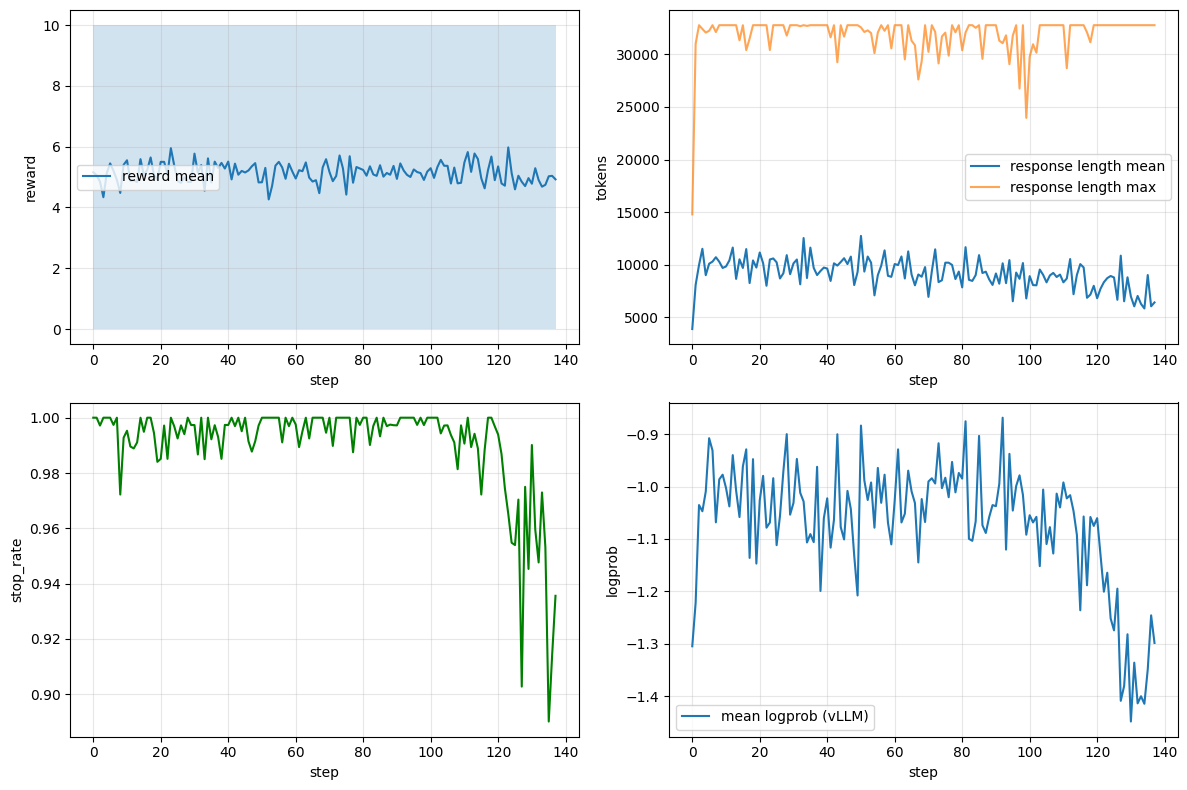

In [14]:
# Plot reward and response length vs step (if matplotlib available)
try:
    import matplotlib.pyplot as plt

    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    ax = axes[0, 0]
    ax.plot(df["step"], df["reward_mean"], label="reward mean")
    ax.fill_between(df["step"], df["reward_min"], df["reward_max"], alpha=0.2)
    ax.set_xlabel("step")
    ax.set_ylabel("reward")
    ax.legend()
    ax.grid(True, alpha=0.3)

    ax = axes[0, 1]
    ax.plot(df["step"], df["resp_len_mean"], label="response length mean")
    ax.plot(df["step"], df["resp_len_max"], alpha=0.7, label="response length max")
    ax.set_xlabel("step")
    ax.set_ylabel("tokens")
    ax.legend()
    ax.grid(True, alpha=0.3)

    ax = axes[1, 0]
    ax.plot(df["step"], df["stop_rate"], color="green")
    ax.set_xlabel("step")
    ax.set_ylabel("stop_rate")
    ax.grid(True, alpha=0.3)

    ax = axes[1, 1]
    if df["logprob_mean_mean"].notna().any():
        ax.plot(df["step"], df["logprob_mean_mean"], label="mean logprob (vLLM)")
    ax.set_xlabel("step")
    ax.set_ylabel("logprob")
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
except ImportError:
    print("matplotlib not available; skip plots.")

## 5. Sample full records (token IDs only)

In [15]:
for i, rec in enumerate(sample_records):
    print(f"--- Sample {i + 1} (step={rec.get('step')}, sample_idx={rec.get('sample_idx')}) ---")
    print(f"  reward={rec.get('reward')}, advantage={rec.get('advantage')}, finish_reason={rec.get('finish_reason')}")
    print(f"  prompt_tokens: len={len(rec.get('prompt_tokens', []))}")
    print(f"  response_tokens: len={len(rec.get('response_tokens', []))}")
    if rec.get("logprobs"):
        lp = rec["logprobs"]
        valid = [x for x in lp if isinstance(x, (int, float)) and not (isinstance(x, float) and np.isnan(x))]
        if valid:
            print(f"  logprobs: len={len(lp)}, mean={np.mean(valid):.4f}, min={np.min(valid):.4f}, max={np.max(valid):.4f}")
    print()

--- Sample 1 (step=0, sample_idx=0) ---
  reward=10.0, advantage=1.25, finish_reason=stop
  prompt_tokens: len=120
  response_tokens: len=410
  logprobs: len=410, mean=-0.2811, min=-6.8184, max=0.0000

--- Sample 2 (step=1, sample_idx=0) ---
  reward=4.0, advantage=-0.5, finish_reason=stop
  prompt_tokens: len=355
  response_tokens: len=10837
  logprobs: len=10837, mean=-1.1614, min=-16.9347, max=-0.0000

--- Sample 3 (step=2, sample_idx=0) ---
  reward=10.0, advantage=3.75, finish_reason=stop
  prompt_tokens: len=123
  response_tokens: len=24209
  logprobs: len=24209, mean=-0.9040, min=-16.3017, max=0.0000

--- Sample 4 (step=3, sample_idx=0) ---
  reward=0.0, advantage=-3.75, finish_reason=stop
  prompt_tokens: len=286
  response_tokens: len=21412
  logprobs: len=21412, mean=-0.9440, min=-17.2866, max=0.0000

--- Sample 5 (step=4, sample_idx=0) ---
  reward=10.0, advantage=2.5, finish_reason=stop
  prompt_tokens: len=37
  response_tokens: len=20066
  logprobs: len=20066, mean=-0.7726

## 6. Optional: decode tokens to text (requires tokenizer)

In [5]:
# Load tokenizer from metadata model_name (or set MODEL_NAME explicitly)
MODEL_NAME = (metadata or {}).get("model_name", "allenai/OLMo-1B-7B")  # fallback
USE_TOKENIZER = True  # set False to skip tokenizer load and decode

if USE_TOKENIZER:
    try:
        from transformers import AutoTokenizer

        tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)
        print(f"Loaded tokenizer: {MODEL_NAME}")
    except Exception as e:
        print(f"Could not load tokenizer: {e}")
        tokenizer = None
else:
    tokenizer = None
    print("Skipping tokenizer (USE_TOKENIZER=False).")

/mnt/vast/home/lh22zyta/shortcut-RL/open-instruct/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded tokenizer: allenai/Olmo-3-7B-Think-DPO


In [31]:
len(sample_records)

5

In [17]:
if tokenizer is not None and sample_records:
    for i, rec in enumerate(sample_records[:3]):  # decode first 3 only
        print(f"=== Sample {i + 1} (step={rec.get('step')}) ===")
        prompt_ids = rec.get("prompt_tokens", [])
        response_ids = rec.get("response_tokens", [])
        prompt_text = tokenizer.decode(prompt_ids, skip_special_tokens=False)
        response_text = tokenizer.decode(response_ids, skip_special_tokens=False)
        print("[Prompt] (first 500 chars)")
        print(prompt_text[:500])
        print("[Response] (first 800 chars)")
        print(response_text[:800])
        print()
else:
    print("No tokenizer or no sample records; skip decode.")

=== Sample 1 (step=0) ===
[Prompt] (first 500 chars)
<|im_start|>system
You are a helpful AI assistant.<|im_end|>
<|im_start|>user
user: What is the probability of such event happening: Form a word by randomly choosing 2 letters from the multiset {m: 2, o: 3, n: 1}, shuffle the letters in the word, what is the probability of no same letter remains in its original position?
If the probability can be written as the form $\frac{m}{n}$, where $m$ and $n$ are relatively prime integers, find $m + n$.<|im_end|>
<|im_start|>assistant
<think>
[Response] (first 800 chars)
Okay, let's tackle this problem step by step. First, Milena is 7 years old. Her grandmother is 9 times older than her. Hmm, when someone says "X times older," does that mean multiplying the age by X? I think so. So 9 times Milena's age would be 9 * 7. Let me calculate that: 9*7 is 63. So the grandmother is 63 years old.

Next, the grandfather is two years older than the grandmother. If the grandmother is 63, then adding two yea

## 7. Inspect a single step in detail (re-run with STEP_MIN/STEP_MAX)

In [18]:
# Optional: stream again with a narrow step range and larger sample to get many records from one step
def stream_one_step(paths: list[str], target_step: int, max_records: int = 64):
    records = []
    for filepath in paths:
        with open(filepath) as f:
            for line in f:
                line = line.strip()
                if not line:
                    continue
                rec = json.loads(line)
                if rec.get("step") == target_step:
                    records.append(rec)
                    if len(records) >= max_records:
                        return records
    return records


TARGET_STEP = 30  # change to step of interest (e.g. 400, 500)
one_step_records = stream_one_step(paths, TARGET_STEP)
print(f"Records at step {TARGET_STEP}: {len(one_step_records)}")
if one_step_records:
    r0 = one_step_records[0]
    print(f"  reward: {r0.get('reward')}, advantage: {r0.get('advantage')}, finish_reason: {r0.get('finish_reason')}")
    print(f"  response_tokens length: {len(r0.get('response_tokens', []))}")
    if r0.get("logprobs"):
        lp = [x for x in r0["logprobs"] if isinstance(x, (int, float)) and not (isinstance(x, float) and np.isnan(x))]
        if lp:
            print(f"  logprobs: mean={np.mean(lp):.4f}, std={np.std(lp):.4f}")

Records at step 30: 64
  reward: 10.0, advantage: 0.875, finish_reason: stop
  response_tokens length: 16736
  logprobs: mean=-0.6681, std=1.1478


In [57]:
# Compare first and last rollouts (2 each)

def _tail_lines(path: str, n: int):
    # read last n non-empty lines (binary-safe)
    with open(path, 'rb') as f:
        f.seek(0, 2)
        size = f.tell()
        block = bytearray()
        lines = []
        pos = size
        while pos > 0 and len(lines) <= n:
            toread = min(4096, pos)
            pos -= toread
            f.seek(pos)
            data = f.read(toread)
            block = data + block
            lines = block.splitlines()
        return [l.decode('utf-8', 'ignore') for l in lines[-n:]]


def get_first_last_rollouts(paths: list[str], n_each: int = 2):
    first = []
    last = []
    # collect first records from files in order
    for p in paths:
        with open(p) as f:
            for line in f:
                line = line.strip()
                if not line:
                    continue
                first.append(json.loads(line))
                if len(first) >= n_each:
                    break
        if len(first) >= n_each:
            break
    # collect last records from files in reverse order
    for p in reversed(paths):
        try:
            tail = _tail_lines(p, n_each * 2)  # read a few to skip blanks
        except Exception:
            tail = []
        for line in reversed(tail):
            if not line.strip():
                continue
            try:
                last.append(json.loads(line))
            except Exception:
                continue
            if len(last) >= n_each:
                break
        if len(last) >= n_each:
            break
    last = list(reversed(last))  # keep chronological order for the late set
    return first, last


def summarize_and_decode(records: list[dict], label: str, tokenizer=None, max_chars=800):
    print(f'=== {label} ({len(records)} records) ===')
    for i, r in enumerate(records):
        print(f'-- {label} #{i+1}: step={r.get("step")}, sample_idx={r.get("sample_idx")}')
        print(f'   reward={r.get("reward")}, advantage={r.get("advantage")}, finish_reason={r.get("finish_reason")}')
        prompt_ids = r.get('prompt_tokens', [])
        resp_ids = r.get('response_tokens', [])
        print(f'   prompt_len={len(prompt_ids)}, response_len={len(resp_ids)}')
        lp = r.get('logprobs')
        if lp:
            valid = [x for x in lp if isinstance(x, (int, float)) and not (isinstance(x, float) and np.isnan(x))]
            if valid:
                print(f'   logprobs: n={len(lp)}, mean={np.mean(valid):.4f}, std={np.std(valid):.4f}')
        if tokenizer is not None:
            try:
                ptext = tokenizer.decode(prompt_ids, skip_special_tokens=False)
                rtext = tokenizer.decode(resp_ids, skip_special_tokens=False)
                print('   [Prompt] (first 300 chars)')
                print(ptext[:].replace('\n', ' '))
                print('   [Response] (first 600 chars)')
                print(rtext[:].replace('\n', ' '))
            except Exception as e:
                print(f'   decode failed: {e}')
        print()


# Run comparison (2 earliest, 2 latest)
early, late = get_first_last_rollouts(paths, n_each=2)
# load tokenizer if available (reuse earlier `tokenizer` variable if set)
tk = globals().get('tokenizer', None)
summarize_and_decode(early, 'EARLY', tokenizer=tk)
summarize_and_decode(late, 'LATE', tokenizer=tk)


=== EARLY (2 records) ===
-- EARLY #1: step=0, sample_idx=0
   reward=10.0, advantage=2.5, finish_reason=stop
   prompt_len=120, response_len=384
   logprobs: n=384, mean=-0.2183, std=0.5515
   [Prompt] (first 300 chars)
<|im_start|>system You are a helpful AI assistant.<|im_end|> <|im_start|>user user: What is the probability of such event happening: Form a word by randomly choosing 2 letters from the multiset {m: 2, o: 3, n: 1}, shuffle the letters in the word, what is the probability of no same letter remains in its original position? If the probability can be written as the form $\frac{m}{n}$, where $m$ and $n$ are relatively prime integers, find $m + n$.<|im_end|> <|im_start|>assistant <think>
   [Response] (first 600 chars)
Okay, let's tackle this problem step by step. First, Milena is 7 years old. Her grandmother is 9 times older than her. Hmm, when someone says "X times older," does that mean multiplying the age by X? I think so. So 9 times Milena's age would be 9 * 7. Let me c

In [9]:
# Print one (or more) task-response examples per step (memory-efficient)

def print_task_response_per_step(paths: list[str], tokenizer=None, max_steps: int | None = None, max_examples_per_step: int = 1):
    """Stream rollouts and print up to `max_examples_per_step` examples per step.

    - `paths`: list of rollout JSONL files
    - `tokenizer`: optional tokenizer for decoding token ids
    - `max_steps`: if provided, ignore records with step > max_steps
    - `max_examples_per_step`: how many examples to keep/print per step
    """
    from collections import defaultdict

    examples = defaultdict(list)  # step -> list[rec]

    for filepath in paths:
        try:
            with open(filepath) as f:
                for raw in f:
                    line = raw.strip()
                    if not line:
                        continue
                    try:
                        rec = json.loads(line)
                    except Exception:
                        continue
                    step = rec.get('step')
                    if step is None:
                        continue
                    if max_steps is not None and step > max_steps:
                        continue
                    if len(examples[step]) < max_examples_per_step:
                        examples[step].append(rec)
        except Exception:
            continue

    if not examples:
        print('No records found for given paths.')
        return

    for step in sorted(examples.keys()):
        # if step % 10 == 0:
        for i, r in enumerate(examples[step]):
            print(f'=== STEP {step}  (example {i+1}/{len(examples[step])}) ===')
            print(f"  reward={r.get('reward')}, advantage={r.get('advantage')}, finish_reason={r.get('finish_reason')}")
            pids = r.get('prompt_tokens', [])
            rids = r.get('response_tokens', [])
            print(f'  prompt_len={len(pids)}, response_len={len(rids)}')
            lp = r.get('logprobs')
            if lp:
                try:
                    import numpy as _np
                    valid = [x for x in lp if isinstance(x, (int, float)) and not (isinstance(x, float) and _np.isnan(x))]
                    if valid:
                        print(f'  logprobs: n={len(lp)}, mean={_np.mean(valid):.4f}, std={_np.std(valid):.4f}')
                except Exception:
                    pass

            if tokenizer is not None:
                try:
                    ptext = tokenizer.decode(pids, skip_special_tokens=False)
                    rtext = tokenizer.decode(rids, skip_special_tokens=False)
                    if 'Milena' in ptext:
                        print('  [Prompt] (first 400 chars)')
                        print('   ', ptext[:400].replace('\n', ' '))
                    if 'Milena' in rtext:
                        print('  [Response] (first 800 chars)')
                        print('   ', rtext[:800].replace('\n', ' '))
                except Exception as e:
                    print('  decode failed:', e)

# Run the per-step printer with default options (prints 1 example per step)
print_task_response_per_step(paths, tokenizer=globals().get('tokenizer', None), max_steps=None, max_examples_per_step=1000)


=== STEP 0  (example 1/424) ===
  reward=10.0, advantage=2.5, finish_reason=stop
  prompt_len=120, response_len=384
  logprobs: n=384, mean=-0.2183, std=0.5515
  [Response] (first 800 chars)
    Okay, let's tackle this problem step by step. First, Milena is 7 years old. Her grandmother is 9 times older than her. Hmm, when someone says "X times older," does that mean multiplying the age by X? I think so. So 9 times Milena's age would be 9 * 7. Let me calculate that: 9*7 is 63. So the grandmother is 63 years old.  Next, the grandfather is two years older than the grandmother. If the grandmother is 63, then adding two years gives the grandfather's age: 63 + 2 = 65. So the grandfather is 65 years old.  Now, the question is the age difference between Milena and her grandfather. Milena is 7, grandfather is 65. To find the difference, subtract Milena's age from the grandfather's age: 65 - 7. Let me do that subtraction: 65 minus 7 is 58. So the age difference should be 58 years.  Wait a s
=== 